# かがわAIゼミナール通し課題 KickstarterProjects
クラウドファンディング実施前に成功/失敗を予測するモデルを作成する  
・過学習をしている場合は正則化をする。  
・標準化は必ずする。標準化するときはtrain、testで分けている場合はtrainだけでfitして、標準化する。将来入ってくるデータを先に使ってはいけない

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split
import datetime as dt

## 1.CSVデータ読込  

欠損データについて
name 4  
usd pledged 3797  
  
nameは説明変数として使用予定、usd pledgedはクラウドファンディング終了後でないとわからないため使用しない  
nameが欠損しているデータは削除する  

読込直後の件数
378661


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

欠損値削除後の件数
378657


failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

ステータスをsuccessful、failedに絞った件数
331672


,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,failed,successful
goal,1.000,0.008,0.005,0.006,0.006,0.953,0.025,-0.025
pledged,0.008,1.000,0.717,0.858,0.954,0.006,-0.110,0.110
backers,0.005,0.717,1.000,0.697,0.752,0.005,-0.126,0.126
usd pledged,0.006,0.858,0.697,1.000,0.908,0.007,-0.096,0.096
usd_pledged_real,0.006,0.954,0.752,0.908,1.000,0.006,-0.108,0.108
usd_goal_real,0.953,0.006,0.005,0.007,0.006,1.000,0.024,-0.024
failed,0.025,-0.110,-0.126,-0.096,-0.108,0.024,1.000,-1.000
successful,-0.025,0.110,0.126,0.096,0.108,-0.024,-1.000,1.000


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,failed,successful
count,331672,331672,331672,331672,331672,331672.000,331672,331672.000,331672,331672.000,331672,331462.000,331672.000,331672.000,331672.000,331672.000
unique,329594,159,15,14,3102,nan,331252,nan,2,nan,23,nan,nan,nan,nan,nan
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,nan,2016-11-01 15:02:40,nan,failed,nan,US,nan,nan,nan,nan,nan
freq,15,18680,56526,261509,612,nan,2,nan,197716,nan,261358,nan,nan,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,44251.259,NaN,10584.098,NaN,116.383,NaN,7684.637,9943.549,41509.659,0.596,0.404
std,NaN,NaN,NaN,NaN,NaN,1117921.720,NaN,101592.186,NaN,965.432,NaN,83209.751,96733.367,1108934.642,0.491,0.491
min,NaN,NaN,NaN,NaN,NaN,0.010,NaN,0.000,NaN,0.000,NaN,0.000,0.000,0.010,0.000,0.000
25%,NaN,NaN,NaN,NaN,NaN,2000.000,NaN,50.000,NaN,2.000,NaN,25.000,50.000,2000.000,0.000,0.000
50%,NaN,NaN,NaN,NaN,NaN,5000.000,NaN,782.055,NaN,15.000,NaN,502.000,788.000,5000.000,1.000,0.000
75%,NaN,NaN,NaN,NaN,NaN,15000.000,NaN,4657.000,NaN,63.000,NaN,3421.000,4608.000,15000.000,1.000,1.000


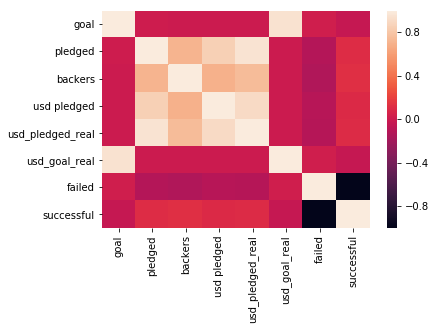

In [31]:
#データ読込
df_ksproj = pd.read_csv("./ks-projects-201801/ks-projects-201801.csv")

print("読込直後の件数")
print(len(df_ksproj))

#不要なデータ/欠損値の確認
display(df_ksproj.isnull().sum())

#nameに欠損があるデータを削除する
df_ksproj = df_ksproj.dropna(subset=['name'])

print("欠損値削除後の件数")
print(len(df_ksproj))

#成功失敗の出現数カウント
display(df_ksproj['state'].value_counts())
#canceled ・・・キャンセル
#undefined ・・・未定義
#live ・・・生きている(進行中)
#suspended ・・・中断

#大半がfailedとsuccessfulのため、それ以外はいったん無視する
df_ksproj = df_ksproj[df_ksproj['state'].isin(["successful", "failed"])]

print("ステータスをsuccessful、failedに絞った件数")
print(len(df_ksproj))

#目的変数stateをダミー変数化する
df_ksproj_dummies = pd.get_dummies(df_ksproj['state'])
df_ksproj = pd.merge(df_ksproj, df_ksproj_dummies, left_index=True, right_index=True)

#不要な列を削除する
#ID
df_ksproj = df_ksproj.drop(['ID'], axis=1)

#相関関数を表示
display(df_ksproj.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj.corr())

#統計を表示
pd.options.display.precision = 6
pd.options.display.float_format = '{:.3f}'.format
df_ksproj.describe(include='all')


## 2.クラウドファンディング期間(launched～deadline)と成功率の関係を確認  

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,failed,successful,funding_term
goal,1.000,0.008,0.005,0.006,0.006,0.953,0.025,-0.025,0.023
pledged,0.008,1.000,0.717,0.858,0.954,0.006,-0.110,0.110,0.008
backers,0.005,0.717,1.000,0.697,0.752,0.005,-0.126,0.126,-0.000
usd pledged,0.006,0.858,0.697,1.000,0.908,0.007,-0.096,0.096,0.008
usd_pledged_real,0.006,0.954,0.752,0.908,1.000,0.006,-0.108,0.108,0.009
usd_goal_real,0.953,0.006,0.005,0.007,0.006,1.000,0.024,-0.024,0.022
failed,0.025,-0.110,-0.126,-0.096,-0.108,0.024,1.000,-1.000,0.116
successful,-0.025,0.110,0.126,0.096,0.108,-0.024,-1.000,1.000,-0.116
funding_term,0.023,0.008,-0.000,0.008,0.009,0.022,0.116,-0.116,1.000


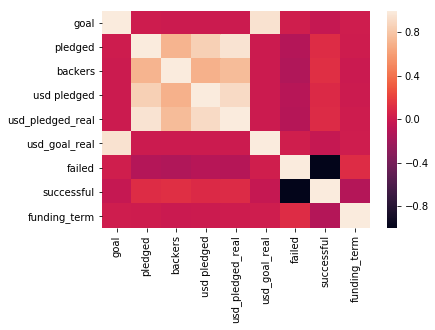

In [32]:
#クラウドファンディング開始～終了までの期間が長ければ成功しやすくなると仮定して、launchedとdeadlineの差を計算する

#日付データをobject型からdatetime型に変換する
df_ksproj['deadline'] = pd.to_datetime(df_ksproj['deadline'])
#launchedから時刻を取り除く
df_ksproj['launched'] = pd.to_datetime(df_ksproj['launched']).dt.date
df_ksproj['launched'] = pd.to_datetime(df_ksproj['launched'])
#クラウドファンディング期間を数値型で用意したfunding_termをデータフレームに追加する
df_ksproj['funding_term'] = df_ksproj['deadline'] - df_ksproj['launched']
df_ksproj['funding_term'] = (df_ksproj['funding_term'] / np.timedelta64(1, 'D')).astype(int)

#相関関数を表示
display(df_ksproj.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj.corr())

## 3.メインカテゴリと成功率の関係を確認  

In [34]:
#メインカテゴリごとに成功率を出してみる
#カテゴリはメインカテゴリと似ているが、細かすぎるので使わない
df_ksproj_groupbycategoryAndstate = df_ksproj.groupby(['main_category', 'state']).size()
print("カテゴリごとのsuccessfulとfailedの件数")
display(df_ksproj_groupbycategoryAndstate)

#機能：メインカテゴリの成功率を表示する
#引数：categoryStr データセット内のメインカテゴリの名称
def checkSuccessRate(categoryStr):
    categorySucRate = df_ksproj_groupbycategoryAndstate[categoryStr,'successful']/df_ksproj_groupbycategoryAndstate[categoryStr].sum()
    print("{} Success Rate:{}%".format(categoryStr, math.ceil(categorySucRate*100)))
    
checkSuccessRate('Art')
checkSuccessRate('Comics')
checkSuccessRate('Crafts')
checkSuccessRate('Dance')
checkSuccessRate('Design')
checkSuccessRate('Fashion')
checkSuccessRate('Film & Video')
checkSuccessRate('Food')
checkSuccessRate('Games')
checkSuccessRate('Journalism')
checkSuccessRate('Music')
checkSuccessRate('Photography')
checkSuccessRate('Publishing')
checkSuccessRate('Technology')
checkSuccessRate('Theater')

#成功しやすいメインカテゴリの区分をデータフレームに追加する(Success > 50%のメインカテゴリ)
#対象のメインカテゴリ Comics 60% Dance 66% Music 53% Theater 64%
df_ksproj = df_ksproj.assign(SuccessHighCategory = 0)
df_ksproj.loc[df_ksproj['main_category'].isin(['Comics', 'Dance', 'Music', 'Theater']),'SuccessHighCategory'] = 1

#display(df_ksproj.head(5))


カテゴリごとのsuccessfulとfailedの件数


main_category  state     
Art            failed        14130
               successful    11510
Comics         failed         4036
               successful     5842
Crafts         failed         5703
               successful     2115
Dance          failed         1235
               successful     2338
Design         failed        14814
               successful    10550
Fashion        failed        14182
               successful     5593
Film & Video   failed        32903
               successful    23623
Food           failed        15969
               successful     6085
Games          failed        16002
               successful    12518
Journalism     failed         3137
               successful     1012
Music          failed        21752
               successful    24197
Photography    failed         6384
               successful     3305
Publishing     failed        23145
               successful    12300
Technology     failed        20616
               successful    

Art Success Rate:45%
Comics Success Rate:60%
Crafts Success Rate:28%
Dance Success Rate:66%
Design Success Rate:42%
Fashion Success Rate:29%
Film & Video Success Rate:42%
Food Success Rate:28%
Games Success Rate:44%
Journalism Success Rate:25%
Music Success Rate:53%
Photography Success Rate:35%
Publishing Success Rate:35%
Technology Success Rate:24%
Theater Success Rate:64%


## 4.プロジェクト名称と成功率の関係を確認  

C:\Users\PC17001X\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,name,successful,failed,nameLength
0,The Songs of Adelaide & Abullah,0,1,26
1,Greeting From Earth: ZGAC Arts Capsule For ET,0,1,38
2,Where is Hank?,0,1,12
3,ToshiCapital Rekordz Needs Help to Complete Album,0,1,43
5,Monarch Espresso Bar,1,0,18
6,Support Solar Roasted Coffee & Green Energy! ...,1,0,52
7,Chaser Strips. Our Strips make Shots their B*tch!,0,1,42
10,Of Jesus and Madmen,0,1,16
11,Lisa Lim New CD!,1,0,13
12,The Cottage Market,0,1,16


,successful,failed,nameLength
successful,1.000,-1.000,0.100
failed,-1.000,1.000,-0.100
nameLength,0.100,-0.100,1.000


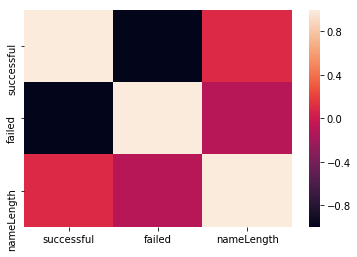

In [35]:
#プロジェクト名称が何をするのか具体的なほうがよいみたい⇒nameの文字数が多いほうがSuccessfulが高いか確認する
#https://entreplanner.jp/crowdfunding/crowdfunding-biz2
#https://agri.mynavi.jp/2018_10_09_42497/

#nameの文字数と成功の関係を確認するために、項目を抜き出したデータセットを作成する
df_ksproj_NameAndState = df_ksproj[['name', 'successful', 'failed']]
df_ksproj_NameAndState['nameLength'] = df_ksproj_NameAndState['name'].apply(lambda x: len(str(x).replace(' ', '')))

display(df_ksproj_NameAndState.head(10))

#相関関数を表示
display(df_ksproj_NameAndState.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj_NameAndState.corr())

#nameの文字数とsuccessfulに0.1の相関がみられたので説明変数として使う
df_ksproj['nameLength'] = df_ksproj_NameAndState['nameLength']


## 5.説明変数の選択  

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,failed,successful,funding_term,SuccessHighCategory,nameLength
goal,1.000,0.008,0.005,0.006,0.006,0.953,0.025,-0.025,0.023,-0.013,-0.005
pledged,0.008,1.000,0.717,0.858,0.954,0.006,-0.110,0.110,0.008,-0.030,0.034
backers,0.005,0.717,1.000,0.697,0.752,0.005,-0.126,0.126,-0.000,-0.026,0.024
usd pledged,0.006,0.858,0.697,1.000,0.908,0.007,-0.096,0.096,0.008,-0.023,0.025
usd_pledged_real,0.006,0.954,0.752,0.908,1.000,0.006,-0.108,0.108,0.009,-0.029,0.033
usd_goal_real,0.953,0.006,0.005,0.007,0.006,1.000,0.024,-0.024,0.022,-0.012,-0.005
failed,0.025,-0.110,-0.126,-0.096,-0.108,0.024,1.000,-1.000,0.116,-0.163,-0.100
successful,-0.025,0.110,0.126,0.096,0.108,-0.024,-1.000,1.000,-0.116,0.163,0.100
funding_term,0.023,0.008,-0.000,0.008,0.009,0.022,0.116,-0.116,1.000,0.029,0.014
SuccessHighCategory,-0.013,-0.030,-0.026,-0.023,-0.029,-0.012,-0.163,0.163,0.029,1.000,0.043


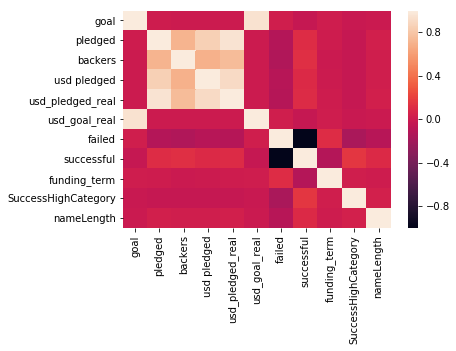

In [36]:
#説明変数として使用する項目の選択

#相関関数を表示
display(df_ksproj.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj.corr())

#カテゴリ項目stateのsuccessfulを数値項目に変換したsuccessfulと相関がみられる項目は以下の通り
#pledged(0.110) backers(0.126) usd pledged(0.096) usd_pledged_real(0.108) SuccessHighCategory(0.163) nameLength(0.100)
#この中からクラウドファンディング開始前にわからない項目は除外する
#backers:支援者の数は終わってみないと判断がつかない、Pledge***：これも集まった金額なので終わってみないと判断がつかない
#説明変数として使用する項目
#SuccessHighCategory(0.163) nameLength(0.100)


,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
currency_AUD,1.000,-0.028,-0.006,-0.008,-0.030,-0.045,-0.005,-0.001,-0.009,-0.006,...,-0.001,-0.002,-0.009,0.001,-0.012,-0.006,-0.009,-0.010,-0.005,-0.275
currency_CAD,-0.028,1.000,-0.009,-0.010,-0.042,-0.061,-0.007,-0.002,-0.013,-0.008,...,-0.002,-0.003,-0.013,-0.002,-0.017,-0.008,-0.012,-0.013,-0.007,-0.380
currency_CHF,-0.006,-0.009,1.000,-0.002,-0.009,-0.014,-0.002,-0.000,-0.003,-0.002,...,-0.000,-0.001,-0.003,-0.001,-0.004,-0.002,-0.003,-0.003,-0.002,-0.086
currency_DKK,-0.008,-0.010,-0.002,1.000,-0.011,-0.017,-0.002,-0.000,-0.003,-0.002,...,-0.000,-0.001,-0.003,0.005,-0.005,-0.002,-0.003,-0.004,-0.002,-0.102
currency_EUR,-0.030,-0.042,-0.009,-0.011,1.000,-0.066,-0.008,-0.002,-0.014,-0.009,...,-0.002,0.062,-0.014,0.007,0.402,-0.009,-0.013,-0.014,-0.008,-0.410
currency_GBP,-0.045,-0.061,-0.014,-0.017,-0.066,1.000,-0.012,-0.003,-0.020,-0.013,...,-0.003,-0.004,-0.020,0.001,-0.027,-0.013,-0.019,-0.021,-0.012,-0.602
currency_HKD,-0.005,-0.007,-0.002,-0.002,-0.008,-0.012,1.000,-0.000,-0.002,-0.002,...,-0.000,-0.000,-0.002,-0.001,-0.003,-0.002,-0.002,-0.003,-0.001,-0.073
currency_JPY,-0.001,-0.002,-0.000,-0.000,-0.002,-0.003,-0.000,1.000,-0.001,-0.000,...,1.000,-0.000,-0.001,-0.000,-0.001,-0.000,-0.001,-0.001,-0.000,-0.016
currency_MXN,-0.009,-0.013,-0.003,-0.003,-0.014,-0.020,-0.002,-0.001,1.000,-0.003,...,-0.001,-0.001,1.000,-0.002,-0.006,-0.003,-0.004,-0.004,-0.002,-0.126
currency_NOK,-0.006,-0.008,-0.002,-0.002,-0.009,-0.013,-0.002,-0.000,-0.003,1.000,...,-0.000,-0.001,-0.003,0.005,-0.004,0.998,-0.003,-0.003,-0.002,-0.081


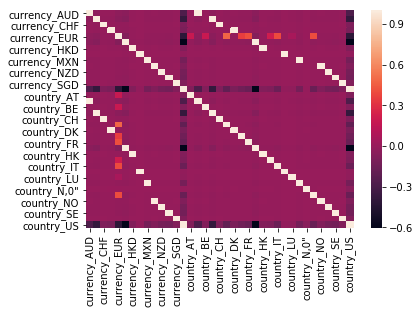

In [38]:
#2019/09/11 説明変数として使っていないので不要。うまく処理してcurrencyは説明変数として使いたい。

#カテゴリ項目を数値項目に変換
#LabelEncoderは変換後の数値に重みがでてしまう
#pd.get_dummies(dataframe)を使用して、数値項目に変換する

#必要な項目だけ変換
df_ksproj_dummies = pd.get_dummies(df_ksproj[['currency', 'country']])
#df_ksproj = pd.merge(df_ksproj, df_ksproj_dummies, left_index=True, right_index=True)

display(df_ksproj_dummies.head(5))

#カテゴリ変数を数値項目に変換したので、改めて相関関数とヒートマップで可視化
#相関関数を表示
display(df_ksproj_dummies.corr())

#ヒートマップを表示
sns.heatmap(df_ksproj_dummies.corr())


## 6.学習/予測

In [40]:
#ロジスティック回帰実装
#y = df_ksproj['state'].values
#X = df_ksproj[['currency','SuccessHighCategory']].values
y = df_ksproj['successful'].values
X = df_ksproj[['nameLength','SuccessHighCategory']].values

#学習データと予測データに分割する(80%:学習データ 20%:予測データ)
#分割の参考サイト⇒https://qiita.com/terapyon/items/8f8d3518ee8eeb4f96b2
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

#loss:使用する損失関数 log⇒ロジスティック回帰、確率的分類子
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
#学習用データを使って学習する
clf.fit(X_train, y_train)

#ラベルを予測
#y_pred = clf.predict(X)
#学習用データでの予測
y_train_pred = clf.predict(X_train)
#予測用データでの予測
y_val_pred = clf.predict(X_val)

#正答率を計算
#accuracy =  accuracy_score(y, y_pred)
#print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))
train_score = accuracy_score(y_train, y_train_pred)
val_score = accuracy_score(y_val, y_val_pred)

#Precision, Recall, F1-scoreを計算
#precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(y_train, y_train_pred)
val_precision, val_recall, val_f1_score, _ = precision_recall_fscore_support(y_val, y_val_pred)

print('学習用データでの正答率（Accuracy） = {:.3f}%'.format(100 * train_score))
print('学習用データでの適合率（Precision） = {:.3f}%'.format(100 * train_precision[0]))
print('学習用データでの再現率（Recall） = {:.3f}%'.format(100 * train_recall[0]))
print('学習用データでのF1値（F1-score） = {:.3f}%'.format(100 * train_f1_score[0]))

print('予測用データでの正答率（Accuracy） = {:.3f}%'.format(100 * val_score))
print('予測用データでの適合率（Precision） = {:.3f}%'.format(100 * val_precision[0]))
print('予測用データでの再現率（Recall） = {:.3f}%'.format(100 * val_recall[0]))
print('予測用データでのF1値（F1-score） = {:.3f}%'.format(100 * val_f1_score[0]))

#初回の実行結果
#学習用データでの正答率（Accuracy） = 62.080%
#学習用データでの適合率（Precision） = 63.607%
#学習用データでの再現率（Recall） = 85.095%
#学習用データでのF1値（F1-score） = 72.799%
#予測用データでの正答率（Accuracy） = 62.239%
#予測用データでの適合率（Precision） = 63.657%
#予測用データでの再現率（Recall） = 85.323%
#予測用データでのF1値（F1-score） = 72.915%


C:\Users\PC17001X\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


学習用データでの正答率（Accuracy） = 62.314%
学習用データでの適合率（Precision） = 63.576%
学習用データでの再現率（Recall） = 86.098%
学習用データでのF1値（F1-score） = 73.143%
予測用データでの正答率（Accuracy） = 62.175%
予測用データでの適合率（Precision） = 63.501%
予測用データでの再現率（Recall） = 86.050%
予測用データでのF1値（F1-score） = 73.075%


##### ◆2019/08/31  
　モデル：ロジスティック回帰  
　データ：除外⇒NaN有 stateがsuccessful/failed以外   
　目的変数：state  
　説明変数：currency SuccessHighCategory(成功率が50%以上のmain_category)  
　学習用データでの正答率（Accuracy） = 62.080%  
　学習用データでの適合率（Precision） = 63.607%  
　学習用データでの再現率（Recall） = 85.095%  
　学習用データでのF1値（F1-score） = 72.799%  
　予測用データでの正答率（Accuracy） = 62.239%  
　予測用データでの適合率（Precision） = 63.657%  
　予測用データでの再現率（Recall） = 85.323%  
　予測用データでのF1値（F1-score） = 72.915%  
   
　Accuracyが62%と低い。メインカテゴリの成功率の高さを説明変数で使うのはいいと考えるが、  
　通貨種類でクラウドファンディングが成功/失敗に影響は考えずらい。次回は違う項目を説明変数に使ってみる。  
  
#### ◆2019/09/11  
　モデル：ロジスティック回帰  
　データ：除外⇒NaN有(name) stateがsuccessful/failed以外   
　目的変数：successful  
　説明変数：nameLength SuccessHighCategory(成功率が50%以上のmain_category)  
　学習用データでの正答率（Accuracy） = 62.314%  
　学習用データでの適合率（Precision） = 63.576%  
　学習用データでの再現率（Recall） = 86.098%  
　学習用データでのF1値（F1-score） = 73.143%  
　予測用データでの正答率（Accuracy） = 62.175%  
　予測用データでの適合率（Precision） = 63.501%  
　予測用データでの再現率（Recall） = 86.050%  
　予測用データでのF1値（F1-score） = 73.075%  
  
　プロジェクト名称がそのプロジェクトを具体的に表しているほうがよいみたいなので、説明変数として使用してみた。  
　Accuracyが微増したが、低い。次回はSVMで実装してみる。Currencyも説明変数として使用したいが、get_dummiesすると項目が増えすぎる。  
　次回は正則化・標準化などDay2の内容を取り入れる。